# Credit Card Fraud Detection
In this project I aim to design a model that helps identify Credit Card Fraud
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

/Users/danieldavid/Documents/DataProjects/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/danieldavid/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


## Loading the dataset using pandas

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
import os
df = pd.read_csv(os.path.join(path, 'creditcard.csv'))

# Display first few rows and check for missing data
print(df.head())
print(df.isnull().sum())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

There are no missing values in the data. Dataset looks clean and preprocessed.

## Visulaization of dataset

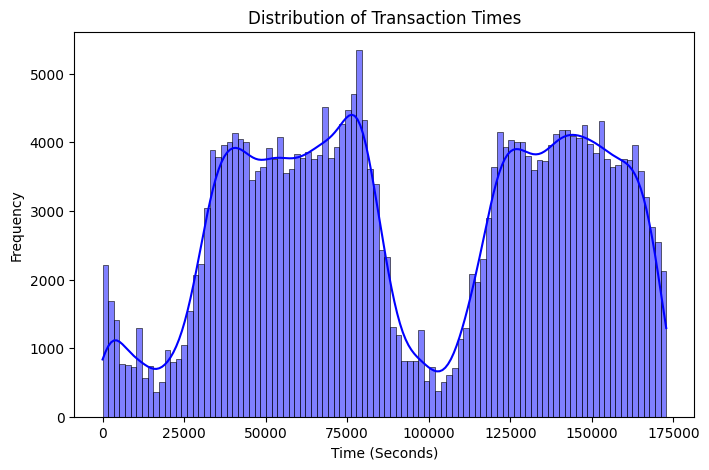

In [15]:
# Visualize the distribution of Time (seconds since the first transaction)
plt.figure(figsize=(8,5))
sns.histplot(df['Time'], bins=100, kde=True, color='blue')
plt.title('Distribution of Transaction Times')
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency')
plt.show()


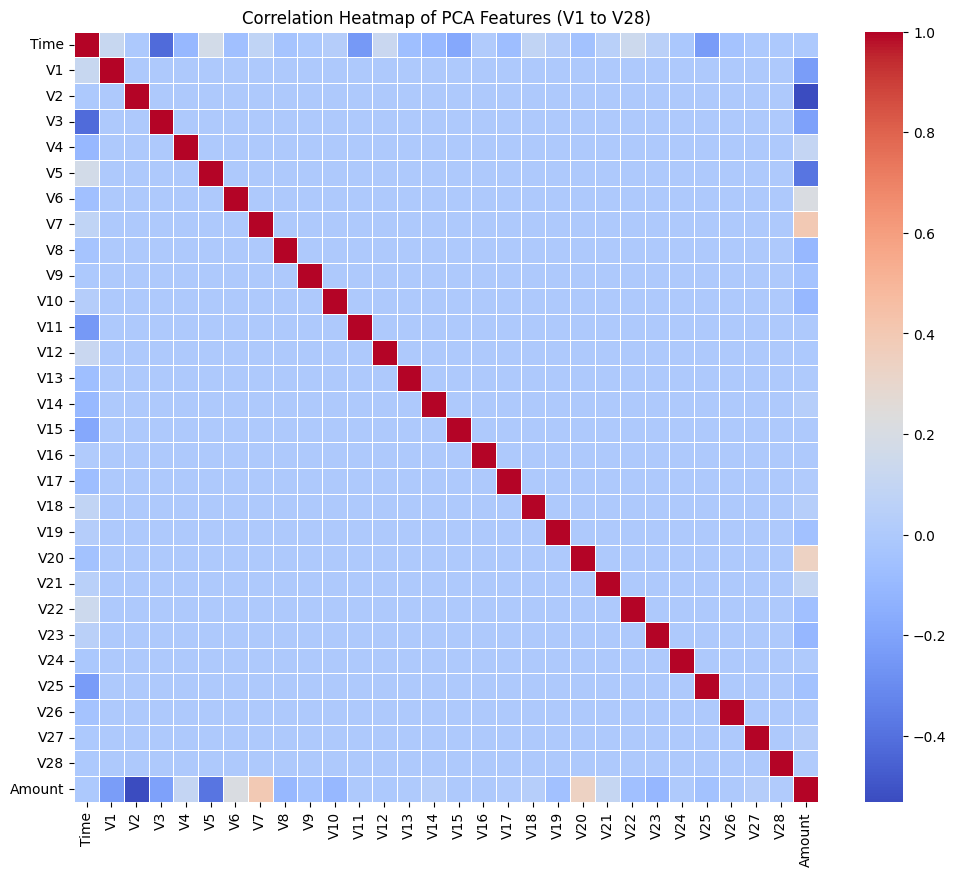

In [16]:
# Correlation heatmap of the PCA features
plt.figure(figsize=(12,10))
sns.heatmap(df.iloc[:, :-1].corr(), cmap='coolwarm', annot=False, fmt='.1f', linewidths=0.5)
plt.title('Correlation Heatmap of PCA Features (V1 to V28)')
plt.show()


/var/folders/n4/5wsglpns5z3d6wy5bjtslbw80000gn/T/ipykernel_50811/752208151.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=df, palette='Set1')


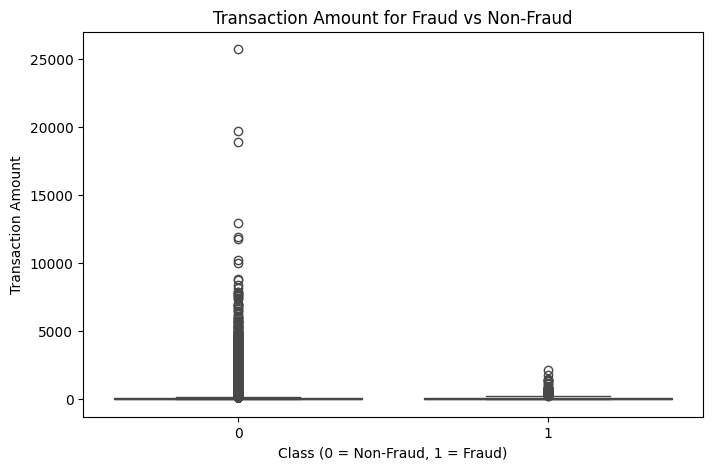

In [17]:
# Visualize the transaction amount distribution for fraud vs. non-fraud transactions
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Amount', data=df, palette='Set1')
plt.title('Transaction Amount for Fraud vs Non-Fraud')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Transaction Amount')
plt.show()


/var/folders/n4/5wsglpns5z3d6wy5bjtslbw80000gn/T/ipykernel_50811/3023947524.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Time', data=df, palette='Set1')


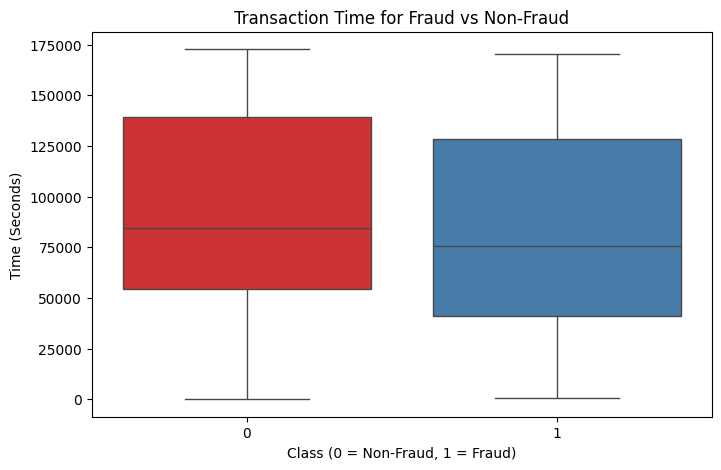

In [18]:
# Visualize the time distribution for fraud vs. non-fraud transactions
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Time', data=df, palette='Set1')
plt.title('Transaction Time for Fraud vs Non-Fraud')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Time (Seconds)')
plt.show()


## Developing Model to detect Fraud

I will be using a Random Forest classifier for credit card fraud detection. The model Handles an imbalanced dataset well, like here where fraudulent transactions are far less frequent than legitimate ones. Random Forest can handle this imbalance well, as it creates multiple decision trees and can balance the prediction across them. Random Forest also provides a way to measure feature importance, which helps in understanding which factorscontribute the most to identifying fraudulent behavior. Fraud detection often involves complex patterns and non-linear relationships between variables. Random Forests can capture these complex patterns better than linear models (e.g., logistic regression), making it more suitable for the dynamic and irregular nature of fraudulent transactions. Random Forests scale well with large datasets, which is crucial in credit card fraud detection.

In [3]:
from imblearn.over_sampling import SMOTE
X = df.drop(['Class'], axis=1)  # Features
y = df['Class']  # Target variable (Fraud: 1, Non-fraud: 0)

# Normalize Time and Amount
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

#Handling class imbalance with SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [4]:
#Training a Random Forest Classifier 
rf_model = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

#Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [5]:
print("Classification Report:\n", classification_report(y_test, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



The Random Forest Classifier model here overfits the data, hence we have a unreasonably high precision, recall and f1-score.

Using K-fold cross-validation to better account for the minority data and reduce overfitting. Since the dataset is imbalanced we can use stratified K-fold cross-validation,instead of splitting the data randomly. The data is divided in such a way that each fold has approximately the same percentage of samples for each class as the original dataset.

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

# Create stratified K-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision = []
recall = []
f1 = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf_model = RandomForestClassifier(n_estimators=75, max_depth=10, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    # Collect metrics for each fold
    precision.append(precision_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))

# Print average metrics across all folds
print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1-score: {np.mean(f1)}")


Precision: 0.8489179939358943
Recall: 0.8211502782931355
F1-score: 0.8346777428920286


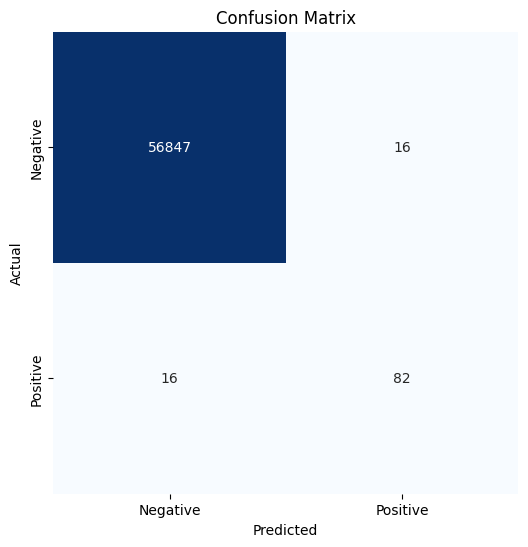

In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

#Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


We can see from the confusion matrix that the model demonstrates strong performance in accurately identifying legitimate transactions, as evidenced by the high number of true negatives. However, the model's performance in detecting fraudulent transactions can be further improved, as indicated by the presence of false negatives. Given the severe consequences associated with failing to detect fraudulent activities, minimizing false negatives is of paramount importance.

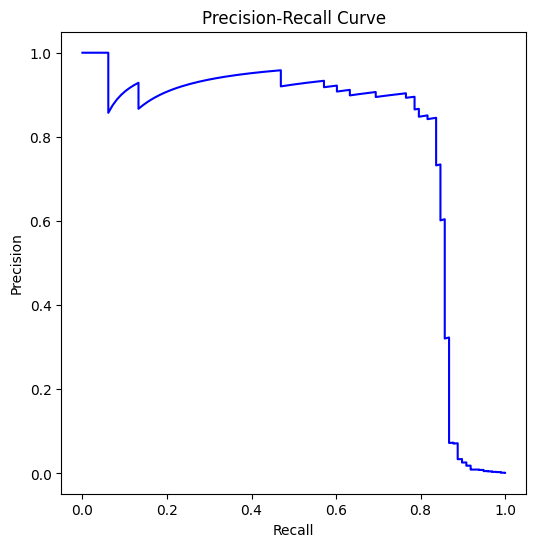

In [11]:
# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, rf_model.predict_proba(X_val)[:,1])
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

The Precision-Recall curve shows that the model has high precision at low recall, meaning it's good at correctly identifying fraud when it's very confident. However, precision drops sharply as recall increases, indicating that the model struggles to identify all fraudulent transactions without increasing false positives. This suggests a need to improve the model's ability to detect fraud without generating too many false alarms.

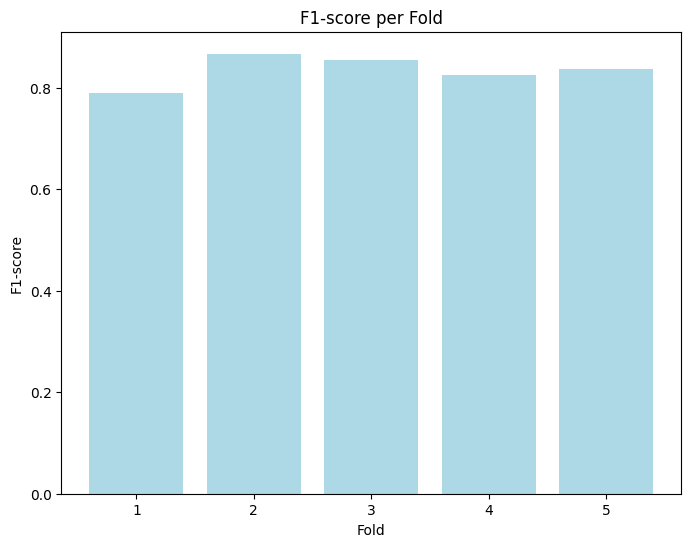

In [12]:
# 3. F1-score per fold (Bar plot)
plt.figure(figsize=(8,6))
plt.bar(range(1, len(f1) + 1), f1, color='lightblue')
plt.xlabel('Fold')
plt.ylabel('F1-score')
plt.title('F1-score per Fold')
plt.show()

The F1 score per fold bar chart shows that the credit card fraud detection model achieves consistent and reasonably high F1-scores across different folds in cross-validation. This indicates that the model is robust and performs well in balancing precision and recall acrross folds.

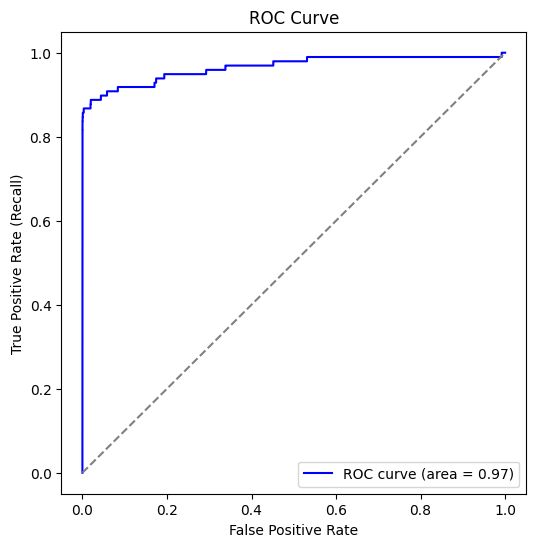

In [13]:
# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='b', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The ROC curve demonstrates that the credit card fraud detection model achieves godd performance, as evidenced by the high AUC of 0.97 and the steep rise in the curve towards the top-left corner. This indicates that the model is highly effective at distinguishing between fraudulent and legitimate transactions, achieving a high true positive rate with a low false positive rate. 

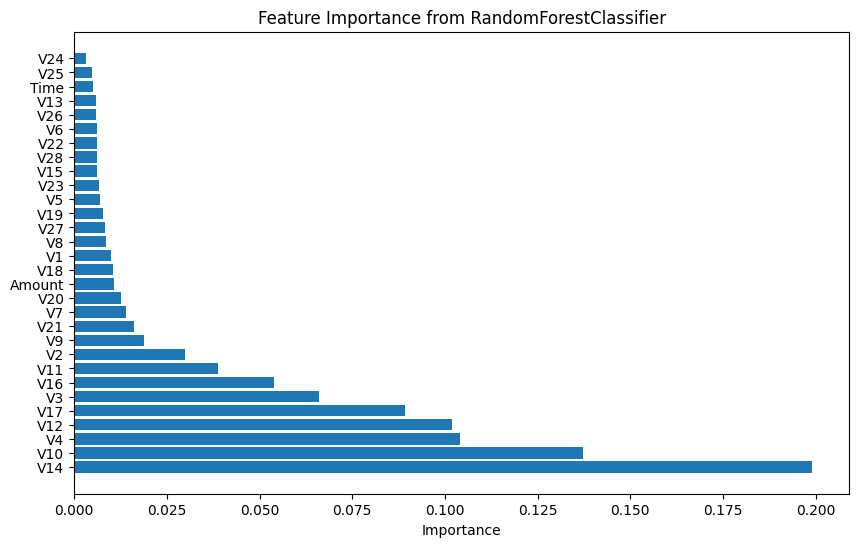

In [14]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from RandomForestClassifier')
plt.show()

The feature importance chart reveals that the Random Forest model relies heavily on a few key features, particularly "V14", for predicting credit card fraud, while not relying too much on parameters like time and amount.

## Further Improvements 

Hyperparameter Tuning can help improve the effectiveness of the Random Forest Classifier.
Trying different classifiers like Gradient Boosting Machines (GBM), XGBoost, or LightGBM, Support Vector Machine (SVM)